# Figure S3: Finite population size simulations

Prerequisites: opt.npz from Figure SIopt, and finite population size simulations results generated with:

    make run
    make agg

Import packages.

In [1]:
import sys
sys.path.append('../lib')
from cycler import cycler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import palettable
import plotting
import analysis
from evolimmune import varname_to_tex, derived_quantities
%load_ext autoreload
%autoreload 2
plt.style.use(['paper'])

use czrecursion, cztogrowthrate
use cstepmarkov


Import results for population of infinite size.

In [2]:
dfinf = analysis.loadnpz('../figSIopt/data/opt.npz')
derived_quantities(dfinf)
analysis.printunique(dfinf)

alpha: 0.005
cup: 0.1*pup+pup**2
deltainit: 0.02
deltatol: 0.005
lambda_: 3.0
logfeps: -9.0
maxf: 10000.0
mus: 1.0-2.0*epsilon/(1.0+epsilon), 1.0+0.8*epsilon
nburnin: 10000.0
niter: 1000000.0


Import results from finite population size simulations.

In [3]:
df = analysis.loadnpz('data/scan.npz')
derived_quantities(df)
analysis.printunique(df)

L: 1.0
cup: 0.1*pup+pup**2
lambda_: 3.0
mus: 1.0-2.0*epsilon/(1.0+epsilon), 1.0+0.8*epsilon
ngen: 100000.0


In [4]:
# number of runs per parameter
df.groupby(by=['nind', 'tauenv', 'ngen', 'pienv']).count().max().max()

500

Putting things together to produce final plot

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


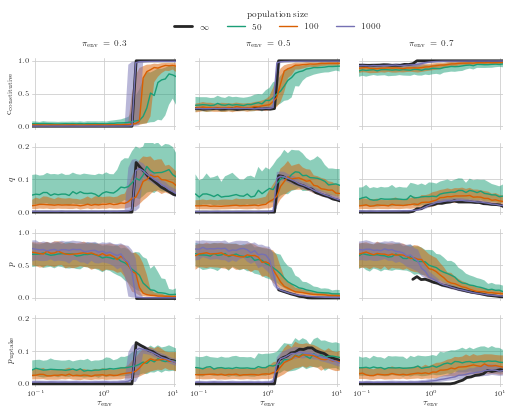

In [5]:
median = True
plt.rc('axes', prop_cycle=cycler('color', palettable.colorbrewer.qualitative.Dark2_6.mpl_colors))
black = matplotlib.rcParams['text.color']
linewidth = matplotlib.rcParams['lines.linewidth']
columns = sorted(df.pienv.unique())
variables = ['cconstitutive',  'q', 'p', 'pup']
ymargin = 0.05
xmargin = 0.02
plotkwargs = dict()
lims = dict(pup=(0, 0.2), q=(0, 0.2))
fig, axes = plt.subplots(ncols=len(columns), nrows=len(variables), figsize=(7.0, 1.0+3.5*len(variables)/len(columns)))
for i, val in enumerate(columns):
    for j, var in enumerate(variables):
        ax = axes[j, i]
        lim = lims[var] if var in lims else (0, 1)
        dlim = lim[1]-lim[0]
        
        closestval = dfinf.ix[(dfinf.pienv-val).abs().argmin()]['pienv']
        dfsub = dfinf[np.abs(dfinf.pienv-closestval)<1e-3]
        dfsub.sort_values(by='tauenv', inplace=True)
        x, y = dfsub.tauenv, dfsub[var]
        ax.plot(x, y, '-', label=r'$\infty$', c=black, lw=linewidth*2, **plotkwargs)
        
        for nind, dfg in sorted(df.groupby(by='nind')):
            dfgg = dfg[df.pienv==val].groupby(by='tauenv', as_index=False)
            dfgg_tauenv = dfgg[['tauenv']].mean()['tauenv']
            if median:
                dfggm = dfgg[[var]].median()[var]
            else:
                dfggm = dfgg[[var]].mean()[var]
            x, y = dfgg_tauenv, dfggm
            line, = ax.plot(x, y, label='%i'%nind, **plotkwargs)
            if median:
                dfggu = dfgg[[var]].quantile(0.75)[var]
                dfggl = dfgg[[var]].quantile(0.25)[var]
            else:
                dfggs = dfgg[[var]].std(ddof=1)[var]
                dfggu = dfggm + dfggs
                dfggl = dfggm - dfggs
            ax.fill_between(dfgg_tauenv, dfggl, dfggu,
                            facecolor=line.get_color(), edgecolor='none', alpha=0.5)

        ax.set_ylim(lim[0]-ymargin*dlim, lim[1]+ymargin*dlim)
        ax.set_xlim(0.09, 11.0)
        ax.set_xscale('log')
        ax.margins(x=xmargin, y=ymargin*dlim)
        plotting.despine(ax, spines='all')
        ax.grid()
        ax.locator_params(axis='y', nbins=5)
ax.legend(loc='upper center', title='population size', bbox_to_anchor=(0.54, 1),
           bbox_transform=plt.gcf().transFigure, ncol=4)
for ax in analysis.flatten(axes[:-1, :]):
    plt.setp(ax.get_xticklabels(), visible=False)
for ax in analysis.flatten(axes[:, 1:]):
    plt.setp(ax.get_yticklabels(), visible=False)
for ax in axes[-1, :]:
    ax.set_xlabel(varname_to_tex['tauenv'])
for j, var in enumerate(variables):
    axes[j, 0].set_ylabel(varname_to_tex[var])
plotting.label_axes(axes[0, :], labels=[(varname_to_tex['pienv'][1:-1] + r'\, = \, %s' % val) for val in columns],
                    labelstyle='$%s$',
                    xy=(.5, 0.9), xycoords=('axes fraction', 'figure fraction'), fontweight = 'bold', fontsize='medium',
                    verticalalignment='top', horizontalalignment='center')
fig.tight_layout(h_pad=1.5, w_pad=1.0, rect=(0.0, 0.0, 1.0, 0.87), pad=0.25)
fig.savefig('SIevol.pdf')

**Influence of finite population size on optimal immune strategies from an agent-based simulation with evolving strategy parameters (switching rates and degree of adaptability) as described in the text.**
For the infinite population, $p$ is only shown for $q > 0$, because for $q = 0$ the value of $p$ is not constrained other than being positive.
Subplots show the median (solid line) and interquartile range (shaded area) of the strategy parameters at the end of a simulation of $100000$ generations length.
Both are calculated from 500 independent simulations.
In each simulation, the strategy parameters evolve from a random initial distribution via mutation and selection.
Mutations take place with a rate $0.01 \exp(-t/10000)$ per generation and are normally distributed with mean zero and standard deviation $0.25 \exp(-t/10000)$.
The bound constraints on the parameters were enforced by setting the strategy parameters to the boundary value if outside after a mutation.
Costs of different immune states as in Fig. 2.